# WellCo Churn Prediction - Complete Pipeline

This notebook runs the end-to-end pipeline using modular code from `src/`.

In [1]:
# Import all modules
import sys
sys.path.insert(0, '..')

# Our modules
from src.data_loader import load_csvs
from src.feature_engineering import build_features
from src.feature_selection import get_XYT, fit_catboost, dr_tau_saved, perm_importance, add_rank, cat_feature_indices
from src.modeling import *  # All model functions
from src.config import *  # All constants

# Standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, average_precision_score
from catboost import CatBoostClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print('✓ All imports successful')


✓ All imports successful


## 1. Load Data

In [2]:
# ============================================================
# CELL 1 — SETUP + LOAD
#   - Loads from DATA_DIR if exists
#   - Otherwise loads from uploaded paths in /mnt/data
# ============================================================

import os
import re
import numpy as np
import pandas as pd

# Optional (for models/eval later)
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, average_precision_score

# ---- Observation window ----
OBS_START = pd.Timestamp("2025-07-01")
OBS_END_INCL = pd.Timestamp("2025-07-15")
OBS_END_EXCL = OBS_END_INCL + pd.Timedelta(days=1)
BIG_RECENCY = 999

# ---- Load helper ----
def load_csvs(data_dir="data/train/"):
    if os.path.exists(os.path.join(data_dir, "churn_labels.csv")):
        base = data_dir
        print(f"[LOAD] Loading from folder: {base}")
        churn  = pd.read_csv(os.path.join(base, "churn_labels.csv"), parse_dates=["signup_date"])
        app    = pd.read_csv(os.path.join(base, "app_usage.csv"), parse_dates=["timestamp"])
        web    = pd.read_csv(os.path.join(base, "web_visits.csv"), parse_dates=["timestamp"])
        claims = pd.read_csv(os.path.join(base, "claims.csv"), parse_dates=["diagnosis_date"])
    else:
        print("[LOAD] Loading from uploaded files in /mnt/data")
        churn  = pd.read_csv("/mnt/data/churn_labels.csv", parse_dates=["signup_date"])
        app    = pd.read_csv("/mnt/data/app_usage.csv", parse_dates=["timestamp"])
        web    = pd.read_csv("/mnt/data/web_visits.csv", parse_dates=["timestamp"])
        claims = pd.read_csv("/mnt/data/claims.csv", parse_dates=["diagnosis_date"])
    return churn, app, web, claims

df_churn, df_app, df_web, df_claims = load_csvs("../data/train/")

print("Shapes:")
print("df_churn :", df_churn.shape)
print("df_app   :", df_app.shape)
print("df_web   :", df_web.shape)
print("df_claims:", df_claims.shape)

print("\nChurn rate:", df_churn["churn"].mean())
print("Outreach rate:", df_churn["outreach"].mean())


[LOAD] Loading from folder: ../data/train/
Shapes:
df_churn : (10000, 4)
df_app   : (97789, 3)
df_web   : (259340, 5)
df_claims: (64576, 3)

Churn rate: 0.2021
Outreach rate: 0.3984


# 2 — Feature Engineering Factory (Claims + App + Web v4) + Variants for experiments (usage)

In [3]:
# ============================================================
# CELL 3B (v3+) — USAGE ONLY
#   - Runs the same sanity checks as your original cell
#   - Keeps variable names 1-to-1: df_counts, df_counts_conc, etc.
# ============================================================

df_counts = build_features(df_churn, df_app, df_web, df_claims, web_mode="counts")
df_counts_conc = build_features(df_churn, df_app, df_web, df_claims, web_mode="counts+conc")

print("counts shape:", df_counts.shape)
print("counts+conc shape:", df_counts_conc.shape)

# Show conc columns exist
conc_cols = [c for c in df_counts_conc.columns if c in ["web_title_entropy","web_title_entropy_norm","web_title_top1_share","web_title_top3_share","web_title_gini"]]
print("New conc columns:", conc_cols)

# Show the NEW composite columns exist
new_cols = [
    "wellco_engagement","clinical_cohort","rfm_norm","risk_uplift_proxy",
    "web_cardiometab_visits","web_nutrition_visits","web_movement_visits","web_sleep_visits","web_resilience_visits"
]
print("New composite columns present:", [c for c in new_cols if c in df_counts_conc.columns])

# Verify counts != counts+conc now
drop_cols = ["member_id","signup_date","churn","outreach"]
X_counts = df_counts.drop(columns=[c for c in drop_cols if c in df_counts.columns], errors="ignore")
X_conc   = df_counts_conc.drop(columns=[c for c in drop_cols if c in df_counts_conc.columns], errors="ignore")

print("X_counts cols:", X_counts.shape[1])
print("X_conc cols:", X_conc.shape[1])
print("Columns added by counts+conc (first 80):", sorted(list(set(X_conc.columns) - set(X_counts.columns)))[:80])


counts shape: (10000, 100)
counts+conc shape: (10000, 105)
New conc columns: ['web_title_entropy', 'web_title_entropy_norm', 'web_title_top1_share', 'web_title_top3_share', 'web_title_gini']
New composite columns present: ['wellco_engagement', 'clinical_cohort', 'rfm_norm', 'risk_uplift_proxy', 'web_cardiometab_visits', 'web_nutrition_visits', 'web_movement_visits', 'web_sleep_visits', 'web_resilience_visits']
X_counts cols: 96
X_conc cols: 101
Columns added by counts+conc (first 80): ['web_title_entropy', 'web_title_entropy_norm', 'web_title_gini', 'web_title_top1_share', 'web_title_top3_share']


/home/weizyuv/vi_labs_assignment/notebooks/../src/feature_engineering.py:465: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[name] = feature_df["member_id"].map(ser).fillna(0)
/home/weizyuv/vi_labs_assignment/notebooks/../src/feature_engineering.py:467: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df["wellco_engagement"] = (


# 3 — Features Selection (Usage)

In [4]:
# ============================================================
# CELL X-USAGE (LEAKAGE-FREE) — RUN + TABLES
#   Produces:
#     - imp_churn
#     - imp_propensity
#     - imp_uplift_proxy
#     - imp_all
#
# Requires:
#   - build_features(...)
#   - df_churn, df_app, df_web, df_claims in memory
# ============================================================

# ============================================================
# 1) Build features (ALL columns)
# ============================================================
df_all = build_features(df_churn, df_app, df_web, df_claims, web_mode=WEB_MODE_FOR_IMPORTANCE).copy()
X, y, t = get_XYT(df_all)

# Split once into TRAIN vs HOLDOUT, stratified by (y,t)
strat = (y * 2 + t)
sss = StratifiedShuffleSplit(n_splits=1, test_size=HOLDOUT_SIZE, random_state=SEED)
tr_idx, ho_idx = next(sss.split(np.arange(len(df_all)), strat))

X_tr, y_tr, t_tr = X.iloc[tr_idx].copy(), y[tr_idx], t[tr_idx]
X_ho, y_ho, t_ho = X.iloc[ho_idx].copy(), y[ho_idx], t[ho_idx]

print("Train:", X_tr.shape, " Holdout:", X_ho.shape)
print("Churn rate train/holdout:", y_tr.mean(), y_ho.mean(), " | Outreach rate train/holdout:", t_tr.mean(), t_ho.mean())

# ============================================================
# 2) Outcome model (predict churn) — fit on TRAIN, eval on HOLDOUT
# ============================================================
m_churn = fit_catboost(X_tr, y_tr, X_ho, y_ho, seed=SEED + 100)

p_churn = m_churn.predict_proba(X_ho)[:, 1]
auc = roc_auc_score(y_ho, p_churn)
pr  = average_precision_score(y_ho, p_churn)
print(f"[Churn model] AUC={auc:.4f} PR-AUC={pr:.4f}")

imp_churn_gain = pd.DataFrame({
    "feature": X_tr.columns,
    "gain": m_churn.get_feature_importance()
}).sort_values("gain", ascending=False).reset_index(drop=True)

imp_churn_perm = perm_importance(m_churn, X_ho, y_ho, scoring="roc_auc", n_repeats=5, seed=SEED)
imp_churn = imp_churn_gain.merge(imp_churn_perm, on="feature", how="left")

# ============================================================
# 3) Propensity model (predict outreach) — fit on TRAIN, eval on HOLDOUT
# ============================================================
m_prop = fit_catboost(X_tr, t_tr, X_ho, t_ho, seed=SEED + 200)
p_prop = m_prop.predict_proba(X_ho)[:, 1]
auc_t = roc_auc_score(t_ho, p_prop)
print(f"[Propensity model] AUC={auc_t:.4f}")

imp_prop_gain = pd.DataFrame({
    "feature": X_tr.columns,
    "gain": m_prop.get_feature_importance()
}).sort_values("gain", ascending=False).reset_index(drop=True)

imp_prop_perm = perm_importance(m_prop, X_ho, t_ho, scoring="roc_auc", n_repeats=5, seed=SEED)
imp_propensity = imp_prop_gain.merge(imp_prop_perm, on="feature", how="left")

# ============================================================
# 4) Uplift-style importance via DR tau_saved on HOLDOUT (leakage-free)
#    Step A: fit nuisance models on TRAIN only
#    Step B: compute tau_saved on HOLDOUT only
#    Step C: fit uplift-proxy classifier on HOLDOUT-subsplit (train/val)
#    Step D: permutation importance on uplift-proxy VAL split
# ============================================================

# A) Fit nuisance models on TRAIN only
# Propensity e(x)
e_model = fit_catboost(X_tr, t_tr, X_ho, t_ho, seed=SEED + 300)

# Outcome models mu0(x), mu1(x) using TRAIN subsets
mask0_tr = (t_tr == 0)
mask1_tr = (t_tr == 1)

# For early stopping we still provide a validation set, but DO NOT fit on it.
# We'll use the same holdout as eval_set; CatBoost won't train on it.
mu0 = fit_catboost(
    X_tr.loc[mask0_tr], y_tr[mask0_tr],
    X_ho.loc[t_ho == 0], y_ho[t_ho == 0],
    seed=SEED + 400
)
mu1 = fit_catboost(
    X_tr.loc[mask1_tr], y_tr[mask1_tr],
    X_ho.loc[t_ho == 1], y_ho[t_ho == 1],
    seed=SEED + 500
)

# B) Compute tau_saved on HOLDOUT only
tau_saved_ho, mu0p_ho, mu1p_ho, ep_ho = dr_tau_saved(mu0, mu1, e_model, X_ho, y_ho, t_ho)
print("[DR HOLDOUT] tau_saved mean:", float(np.mean(tau_saved_ho)), " pos-rate:", float(np.mean(tau_saved_ho > 0)))

# C) Proxy label on HOLDOUT only
uplift_label_ho = (tau_saved_ho > 0).astype(int)

# Split HOLDOUT into proxy-train vs proxy-val (no leakage to earlier fits)
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.35, random_state=SEED + 999)
up_tr_idx, up_va_idx = next(sss2.split(np.arange(len(X_ho)), uplift_label_ho))

X_up_tr = X_ho.iloc[up_tr_idx].copy()
y_up_tr = uplift_label_ho[up_tr_idx]
X_up_va = X_ho.iloc[up_va_idx].copy()
y_up_va = uplift_label_ho[up_va_idx]

m_uplift_proxy = fit_catboost(X_up_tr, y_up_tr, X_up_va, y_up_va, seed=SEED + 600)

# Optional sanity
p_up = m_uplift_proxy.predict_proba(X_up_va)[:, 1]
auc_up = roc_auc_score(y_up_va, p_up) if len(np.unique(y_up_va)) > 1 else np.nan
print(f"[Uplift-proxy] AUC on proxy-val: {auc_up:.4f}" if np.isfinite(auc_up) else "[Uplift-proxy] AUC undefined (single class in proxy-val)")

# D) Permutation importance on proxy-val only (leakage-free)
imp_uplift_proxy = perm_importance(m_uplift_proxy, X_up_va, y_up_va, scoring="roc_auc", n_repeats=10, seed=SEED)
print("\n=== Top 20 uplift-positive predictors (perm, proxy-val) ===")
display(imp_uplift_proxy.head(20))

# ============================================================
# 5) Merge into one table + overall rank
# ============================================================
r1 = add_rank(imp_churn, "perm_mean", "rank_churn_perm")
r2 = add_rank(imp_propensity, "perm_mean", "rank_prop_perm")
r3 = add_rank(imp_uplift_proxy, "perm_mean", "rank_uplift_perm")

imp_all = r1.merge(r2, on="feature", how="outer").merge(r3, on="feature", how="outer")
imp_all["rank_mean"] = imp_all[["rank_churn_perm", "rank_prop_perm", "rank_uplift_perm"]].mean(axis=1, skipna=True)
imp_all = imp_all.sort_values("rank_mean", ascending=True).reset_index(drop=True)

print("\n=== Top 30 features by mean rank (churn/prop/uplift-proxy permutation) ===")
display(imp_all.head(30))

print("\n=== Top 20 churn predictors (perm on holdout) ===")
display(imp_churn.sort_values("perm_mean", ascending=False).head(20))

print("\n=== Top 20 outreach assignment drivers (perm on holdout) ===")
display(imp_propensity.sort_values("perm_mean", ascending=False).head(20))


/home/weizyuv/vi_labs_assignment/notebooks/../src/feature_engineering.py:465: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[name] = feature_df["member_id"].map(ser).fillna(0)
/home/weizyuv/vi_labs_assignment/notebooks/../src/feature_engineering.py:467: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df["wellco_engagement"] = (


Train: (8000, 99)  Holdout: (2000, 99)
Churn rate train/holdout: 0.202 0.2025  | Outreach rate train/holdout: 0.398375 0.3985
0:	learn: 0.6796536	test: 0.6798636	best: 0.6798636 (0)	total: 100ms	remaining: 5m
200:	learn: 0.4493217	test: 0.4772553	best: 0.4772553 (200)	total: 3.69s	remaining: 51.4s
400:	learn: 0.4321097	test: 0.4773671	best: 0.4765854 (304)	total: 7.39s	remaining: 47.9s
bestTest = 0.4765854492
bestIteration = 304
Shrink model to first 305 iterations.
[Churn model] AUC=0.6622 PR-AUC=0.3339
0:	learn: 0.6902794	test: 0.6902109	best: 0.6902109 (0)	total: 21.5ms	remaining: 1m 4s
200:	learn: 0.6206039	test: 0.6396674	best: 0.6395831 (187)	total: 3.75s	remaining: 52.2s
bestTest = 0.6395831299
bestIteration = 187
Shrink model to first 188 iterations.
[Propensity model] AUC=0.6486
0:	learn: 0.6902009	test: 0.6901279	best: 0.6901279 (0)	total: 19.7ms	remaining: 59.1s
200:	learn: 0.6221345	test: 0.6414612	best: 0.6413845 (166)	total: 3.87s	remaining: 53.9s
400:	learn: 0.6021144	te

,feature,perm_mean,perm_std
0,days_since_last_app_session,0.010452,0.005482
1,total_app_sessions,0.007015,0.004783
2,tenure_days_at_obs_start,0.006872,0.002794
3,app_late_sessions,0.006723,0.002181
4,app_active_days,0.006465,0.004396
5,app_visits_per_day,0.005968,0.006864
6,days_since_signup,0.005051,0.003209
7,rfm_norm,0.004918,0.002233
8,app_sessions_per_day,0.003767,0.002823
9,unique_urls_visited,0.003503,0.002192



=== Top 30 features by mean rank (churn/prop/uplift-proxy permutation) ===


,feature,rank_churn_perm,rank_prop_perm,rank_uplift_perm,rank_mean
0,tenure_days_at_obs_start,3.0,3.0,3.0,3.000000
1,days_since_signup,2.0,4.0,7.0,4.333333
2,rfm_norm,4.0,5.0,8.0,5.666667
3,app_late_sessions,5.0,8.0,4.0,5.666667
4,app_sessions_per_day,9.0,1.0,9.0,6.333333
5,total_app_sessions,20.0,2.0,2.0,8.000000
6,app_visits_per_day,11.0,15.0,6.0,10.666667
7,days_since_last_app_session,49.0,12.0,1.0,20.666667
8,has_Z71_3,17.0,31.0,19.0,22.333333
9,web_nutrition_visits,42.0,16.0,13.0,23.666667



=== Top 20 churn predictors (perm on holdout) ===


,feature,gain,perm_mean,perm_std
0,web_health_ratio,13.214406,0.011296,0.003766
2,days_since_signup,5.924432,0.011259,0.001402
3,tenure_days_at_obs_start,5.680102,0.010910,0.001229
5,rfm_norm,4.338061,0.004622,0.000889
7,app_late_sessions,2.612450,0.002461,0.001164
4,risk_uplift_proxy,4.617926,0.002386,0.001335
11,wellco_engagement,1.276136,0.001977,0.001316
9,sessions_per_active_day,1.754184,0.001687,0.000754
28,app_sessions_per_day,0.937702,0.001575,0.000299
25,icd_I10_htn,1.037625,0.001384,0.000503



=== Top 20 outreach assignment drivers (perm on holdout) ===


,feature,gain,perm_mean,perm_std
0,app_sessions_per_day,19.250402,0.022709,0.007123
1,total_app_sessions,16.190032,0.020462,0.005994
2,tenure_days_at_obs_start,3.037969,0.001226,0.001168
7,days_since_signup,2.274186,0.000946,0.000743
14,rfm_norm,1.587573,0.000724,0.000446
13,web_title_cnt__Game_reviews,1.625011,0.000658,0.000343
21,unique_icd_family3,0.955546,0.000565,0.000519
28,app_late_sessions,0.756968,0.000539,0.000206
22,web_title_entropy_norm,0.946013,0.000537,0.000315
42,channels_used,0.563531,0.000526,0.000572


# 4 - Grid Search (Using modeling.py)

[Run] DEVICE: cuda
[Run] FEATURE_TOPK_LIST: [20, 40, 60, 80, 100]
[Run] CHURN_GATE_ALPHAS: [0.2, 0.6, 1.0, 1.2, 1.5]
[Run] MODELS_TO_RUN: ['A_logreg_tlearner', 'B_boost_tlearner', 'C_mlp_twohead']


/home/weizyuv/vi_labs_assignment/notebooks/../src/feature_engineering.py:465: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[name] = feature_df["member_id"].map(ser).fillna(0)
/home/weizyuv/vi_labs_assignment/notebooks/../src/feature_engineering.py:467: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df["wellco_engagement"] = (


[DF] (10000, 105) | churn rate: 0.2021 | outreach rate: 0.3984

[Feature tuning] K_features=20 | n_used=20 | X shape=(10000, 20)

[Propensity] computing OOF ê(x) ...
[Propensity] ê(x) mean: 0.4934481310080048 min/max: 0.09678674893245294 0.999
[Boost] backend: xgboost

FOLD 1/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:13:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:13:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:13:20] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. X


FOLD 2/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:13:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:13:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 3/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:13:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:13:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 4/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:13:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:13:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 5/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:13:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:13:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



[Feature tuning] K_features=40 | n_used=40 | X shape=(10000, 40)

[Propensity] computing OOF ê(x) ...
[Propensity] ê(x) mean: 0.49329304032096416 min/max: 0.09722435124785629 0.999
[Boost] backend: xgboost

FOLD 1/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:13:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:13:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 2/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:13:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:13:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 3/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:13:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:13:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 4/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:13:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:13:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 5/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:13:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:13:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



[Feature tuning] K_features=60 | n_used=60 | X shape=(10000, 60)

[Propensity] computing OOF ê(x) ...
[Propensity] ê(x) mean: 0.4931146383260216 min/max: 0.09237596369536 0.999
[Boost] backend: xgboost

FOLD 1/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:13:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:13:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 2/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:13:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 3/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:14:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:14:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 4/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:14:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:14:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 5/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:14:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:14:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



[Feature tuning] K_features=80 | n_used=80 | X shape=(10000, 80)

[Propensity] computing OOF ê(x) ...
[Propensity] ê(x) mean: 0.4928483509416371 min/max: 0.08834502741918561 0.999
[Boost] backend: xgboost

FOLD 1/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:14:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:14:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 2/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:14:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:14:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 3/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:14:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:14:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 4/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:14:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:14:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 5/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:14:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:14:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



[Feature tuning] K_features=100 | n_used=99 | X shape=(10000, 99)

[Propensity] computing OOF ê(x) ...
[Propensity] ê(x) mean: 0.4928645390399921 min/max: 0.08420989887082155 0.999
[Boost] backend: xgboost

FOLD 1/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:14:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:14:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 2/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:14:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:14:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 3/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:14:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:14:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 4/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:14:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:14:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 5/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:14:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:14:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



=== OOF UPLIFT SUMMARY (feature tuning + assignment metrics only; sorted by AUQC) ===


,K_features,n_used,model,variant,OOF_AUQC,overall_uplift_all,Uplift10,Saved10,Uplift30,Saved30,n_pos(score>0),n_guard(score>0.005)
0,60,60,A_logreg_tlearner,CHURN_INTENSITY=1.5,0.158874,0.038806,0.072057,72.056845,0.058869,176.606915,6876,6122
1,60,60,A_logreg_tlearner,CHURN_INTENSITY=1.2,0.151568,0.038806,0.063756,63.755559,0.059349,178.047587,6876,6316
2,60,60,A_logreg_tlearner,CHURN_INTENSITY=1.0,0.145140,0.038806,0.055037,55.037324,0.061236,183.708772,6876,6412
3,60,60,A_logreg_tlearner,CHURN_INTENSITY=0.6,0.134795,0.038806,0.056920,56.919709,0.058245,174.733658,6876,6567
4,80,80,A_logreg_tlearner,CHURN_INTENSITY=1.5,0.126747,0.038412,0.076857,76.856928,0.067914,203.742804,6731,6002
...,...,...,...,...,...,...,...,...,...,...,...,...
115,20,20,A_logreg_tlearner,CHURN_INTENSITY=1.0,-0.083365,0.038152,0.015584,15.583656,0.029112,87.335623,8172,7435
116,20,20,A_logreg_tlearner,CHURN_INTENSITY=0.6,-0.092966,0.038152,0.036300,36.299511,0.030049,90.146126,8172,7671
117,20,20,A_logreg_tlearner,CHURN_INTENSITY=0.2,-0.100468,0.038152,0.034771,34.771318,0.021661,64.984181,8172,7803
118,100,99,B_boost_tlearner,RAND,-0.103976,0.038530,0.019201,19.200717,0.032822,98.465205,4989,4975



=== Best variant per model (by AUQC) ===


,K_features,n_used,model,variant,OOF_AUQC,overall_uplift_all,Uplift10,Saved10,Uplift30,Saved30,n_pos(score>0),n_guard(score>0.005)
0,60,60,A_logreg_tlearner,CHURN_INTENSITY=1.5,0.158874,0.038806,0.072057,72.056845,0.058869,176.606915,6876,6122
1,80,80,C_mlp_twohead,RAND,0.120194,0.038412,0.045859,45.858514,0.057701,173.101601,5076,5066
2,20,20,B_boost_tlearner,RAND,0.080291,0.038152,0.053527,53.526996,0.062285,186.855761,5043,5029



=== n(k) tables for TOP 6 configurations (k=c/v break-even uplift threshold) ===

--- 1) (60, 'A_logreg_tlearner', 'CHURN_INTENSITY=1.5') | AUQC=0.1589 | Saved10=72.06 | Saved30=176.61 ---


,k_ratio(c/v),n(k)
0,0.000,6876
1,0.002,6541
2,0.005,6122
3,0.010,5427
4,0.020,4230
5,0.050,1824
6,0.100,406
7,0.200,9



--- 2) (60, 'A_logreg_tlearner', 'CHURN_INTENSITY=1.2') | AUQC=0.1516 | Saved10=63.76 | Saved30=178.05 ---


,k_ratio(c/v),n(k)
0,0.000,6876
1,0.002,6643
2,0.005,6316
3,0.010,5790
4,0.020,4724
5,0.050,2414
6,0.100,639
7,0.200,21



--- 3) (60, 'A_logreg_tlearner', 'CHURN_INTENSITY=1.0') | AUQC=0.1451 | Saved10=55.04 | Saved30=183.71 ---


,k_ratio(c/v),n(k)
0,0.000,6876
1,0.002,6674
2,0.005,6412
3,0.010,5976
4,0.020,5075
5,0.050,2846
6,0.100,859
7,0.200,39



--- 4) (60, 'A_logreg_tlearner', 'CHURN_INTENSITY=0.6') | AUQC=0.1348 | Saved10=56.92 | Saved30=174.73 ---


,k_ratio(c/v),n(k)
0,0.000,6876
1,0.002,6746
2,0.005,6567
3,0.010,6259
4,0.020,5627
5,0.050,3734
6,0.100,1519
7,0.200,121



--- 5) (80, 'A_logreg_tlearner', 'CHURN_INTENSITY=1.5') | AUQC=0.1267 | Saved10=76.86 | Saved30=203.74 ---


,k_ratio(c/v),n(k)
0,0.000,6731
1,0.002,6423
2,0.005,6002
3,0.010,5370
4,0.020,4277
5,0.050,2091
6,0.100,575
7,0.200,32



--- 6) (80, 'A_logreg_tlearner', 'CHURN_INTENSITY=1.2') | AUQC=0.1244 | Saved10=73.46 | Saved30=185.23 ---


,k_ratio(c/v),n(k)
0,0.000,6731
1,0.002,6505
2,0.005,6194
3,0.010,5675
4,0.020,4750
5,0.050,2644
6,0.100,839
7,0.200,64


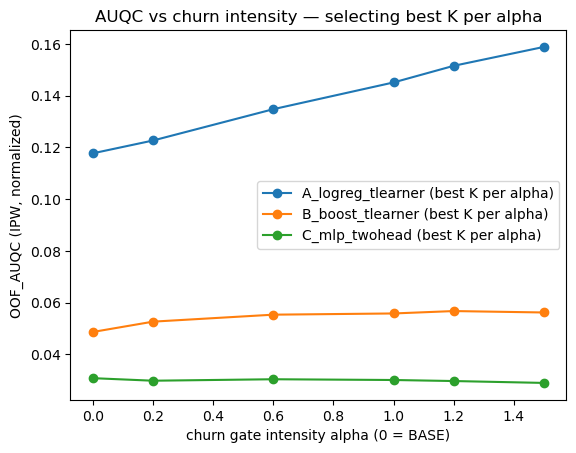


[Best overall pick]
  best_key = (60, 'A_logreg_tlearner', 'CHURN_INTENSITY=1.5') | AUQC=0.1589


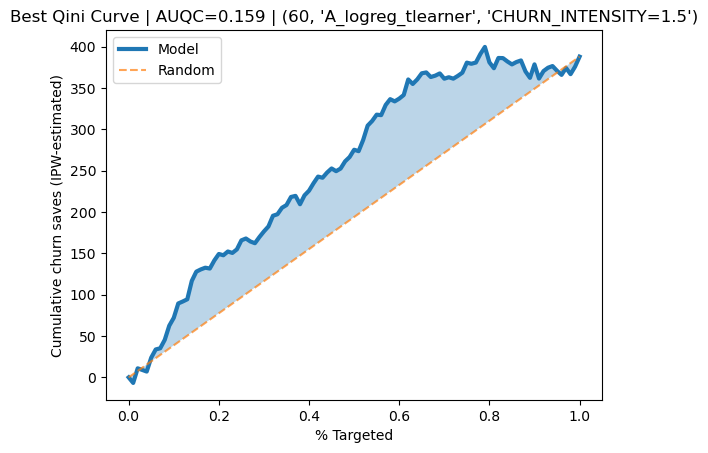


[Recompute best_score] running OOF (ONLY best model) for best K to reconstruct score thresholds...

[Propensity] computing OOF ê(x) ...
[Propensity] ê(x) mean: 0.4931146383260216 min/max: 0.09237596369536 0.999
[Boost] backend: xgboost

FOLD 1/5 | train=8000 test=2000

FOLD 2/5 | train=8000 test=2000

FOLD 3/5 | train=8000 test=2000

FOLD 4/5 | train=8000 test=2000

FOLD 5/5 | train=8000 test=2000


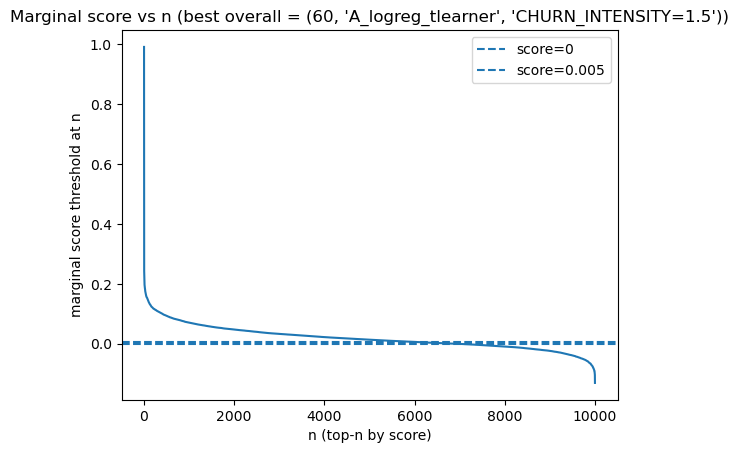

  n_pos (score>0): 6876
  n_guard (score>0.005): 6122

=== Uplift@K report (best overall) ===


,K%,n,uplift,saved,n0_eff,n1_eff,n_t0y0,n_t0y1,n_t1y0,n_t1y1
0,10,1000,0.072057,72.056845,1195.296344,813.337927,434,150,328,88
1,30,3000,0.058869,176.606915,3614.058111,2434.831597,1362,424,970,244


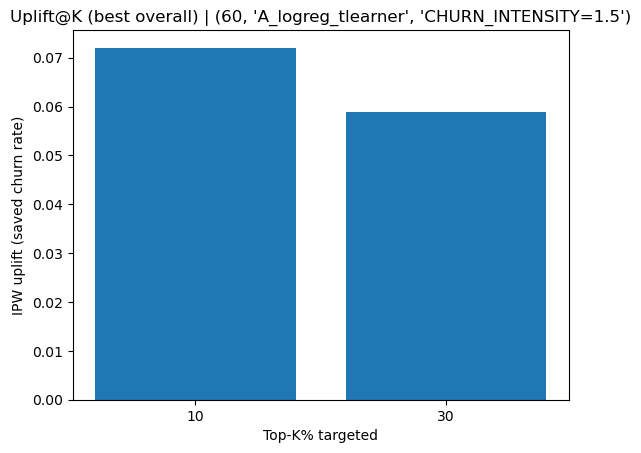


=== Top-3 winners plots ===


,K_features,n_used,model,variant,OOF_AUQC,overall_uplift_all,Uplift10,Saved10,Uplift30,Saved30,n_pos(score>0),n_guard(score>0.005)
0,60,60,A_logreg_tlearner,CHURN_INTENSITY=1.5,0.158874,0.038806,0.072057,72.056845,0.058869,176.606915,6876,6122
1,60,60,A_logreg_tlearner,CHURN_INTENSITY=1.2,0.151568,0.038806,0.063756,63.755559,0.059349,178.047587,6876,6316
2,60,60,A_logreg_tlearner,CHURN_INTENSITY=1.0,0.145140,0.038806,0.055037,55.037324,0.061236,183.708772,6876,6412



[Propensity] computing OOF ê(x) ...
[Propensity] ê(x) mean: 0.4935935815715262 min/max: 0.09719994671113494 0.999
[Boost] backend: xgboost

FOLD 1/5 | train=8000 test=2000

FOLD 2/5 | train=8000 test=2000

FOLD 3/5 | train=8000 test=2000

FOLD 4/5 | train=8000 test=2000

FOLD 5/5 | train=8000 test=2000


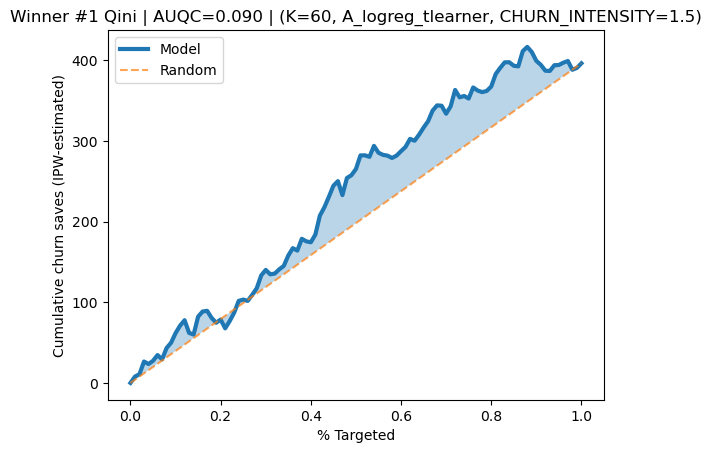

,K%,n,uplift,saved,n0_eff,n1_eff,n_t0y0,n_t0y1,n_t1y0,n_t1y1
0,10,1000,0.061763,61.763431,1193.734550,830.008908,426,151,328,95
1,30,3000,0.046727,140.181357,3680.123498,2376.547266,1397,425,929,249


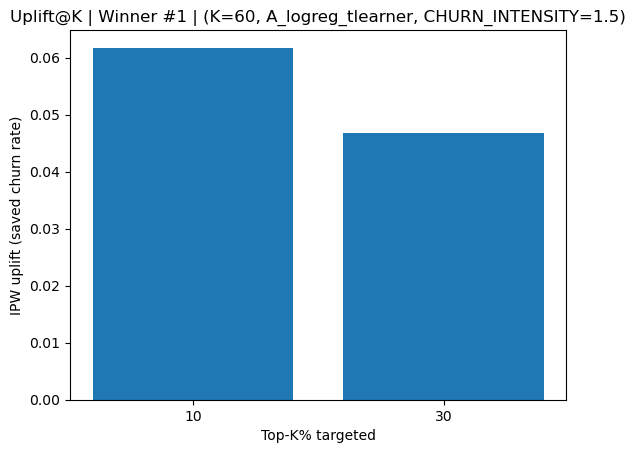


[Propensity] computing OOF ê(x) ...
[Propensity] ê(x) mean: 0.4928002695770824 min/max: 0.09468607449522053 0.999
[Boost] backend: xgboost

FOLD 1/5 | train=8000 test=2000

FOLD 2/5 | train=8000 test=2000

FOLD 3/5 | train=8000 test=2000

FOLD 4/5 | train=8000 test=2000

FOLD 5/5 | train=8000 test=2000


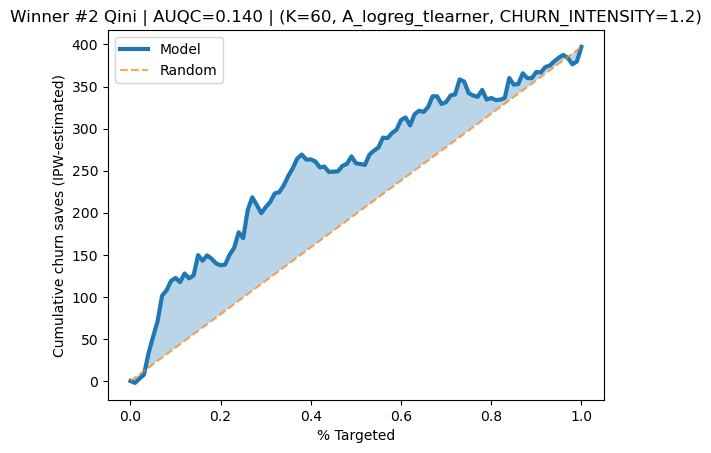

,K%,n,uplift,saved,n0_eff,n1_eff,n_t0y0,n_t0y1,n_t1y0,n_t1y1
0,10,1000,0.122469,122.468941,1261.660091,784.289555,445,166,319,70
1,30,3000,0.068911,206.733885,3649.181698,2427.129711,1392,421,960,227


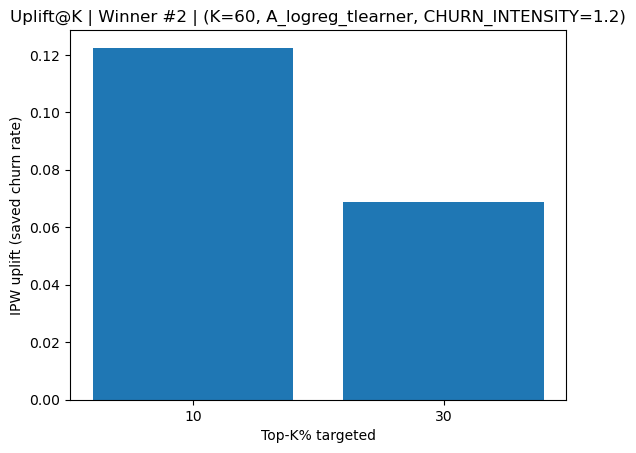


[Propensity] computing OOF ê(x) ...
[Propensity] ê(x) mean: 0.49322472314233545 min/max: 0.09132807130739493 0.999
[Boost] backend: xgboost

FOLD 1/5 | train=8000 test=2000

FOLD 2/5 | train=8000 test=2000

FOLD 3/5 | train=8000 test=2000

FOLD 4/5 | train=8000 test=2000

FOLD 5/5 | train=8000 test=2000


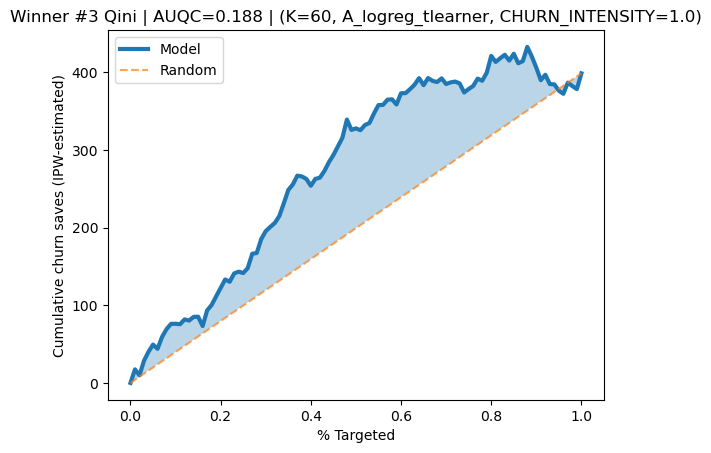

,K%,n,uplift,saved,n0_eff,n1_eff,n_t0y0,n_t0y1,n_t1y0,n_t1y1
0,10,1000,0.076129,76.129003,1284.483388,733.140773,474,157,293,76
1,30,3000,0.065138,195.412594,3604.516372,2422.053077,1398,413,966,223


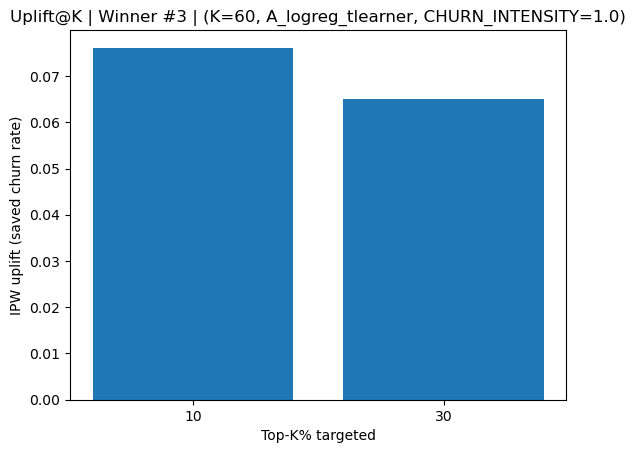

In [5]:
# ============================================================
# CELL 3B — USAGE / RUN (v6.2)
#   Requires:
#     - build_features(...) available
#     - df_final OR df_churn/df_app/df_web/df_claims available
#     - imp_all already computed (recommended) for feature ranking
# ============================================================

from IPython.display import display

# Reset random seeds for reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
print("[Run] DEVICE:", DEVICE)
print("[Run] FEATURE_TOPK_LIST:", FEATURE_TOPK_LIST)
print("[Run] CHURN_GATE_ALPHAS:", CHURN_GATE_ALPHAS)
print("[Run] MODELS_TO_RUN:", MODELS_TO_RUN)

# ---------------------------
# Load DF
# ---------------------------
if "df_final" in globals():
    DF_ALL = df_final.copy()
else:
    web_mode = "counts+conc"
    DF_ALL = build_features(df_churn, df_app, df_web, df_claims, web_mode=web_mode).copy()

print("[DF]", DF_ALL.shape,
      "| churn rate:", float(DF_ALL["churn"].mean()),
      "| outreach rate:", float(DF_ALL["outreach"].mean()))

# ---------------------------
# Prepare ranked features
# ---------------------------
X_full, y, t = get_XYT(DF_ALL)
ranked_features = get_ranked_features_from_imp_all(X_full, imp_all=imp_all)

# ---------------------------
# Run feature tuning
# ---------------------------
rows = []
curves_ipw = {}
n_tables = {}

for Kfeat in FEATURE_TOPK_LIST:
    X_df, n_used = select_topk_X(X_full, ranked_features, Kfeat)

    print("\n" + "="*95)
    print(f"[Feature tuning] K_features={Kfeat} | n_used={n_used} | X shape={X_df.shape}")
    print("="*95)

    e_hat, oof_tau, oof_p0, oof_p1 = run_oof_uplift_models_X(X_df, y, t)

    for model_name in MODELS_TO_RUN:
        base_tau = oof_tau[model_name]
        base_p0  = oof_p0[model_name]

        # IMPORTANT: make RAND deterministic per (K, model)
        variants = build_score_variants(
            base_tau, base_p0, CHURN_GATE_ALPHAS,
            add_risk_baseline=True,
            add_random_baseline=True,
            seed=SEED + 10000 + int(Kfeat) * 31 + stable_hash_int(model_name, 997)
        )

        for variant_name, score in variants:
            key = (int(Kfeat), model_name, variant_name)

            xs, model_curve, rand_curve, auqc, auqc_raw, overall_uplift = \
                qini_curve_and_auqc_ipw(y, t, e_hat, score, n_bins=100)

            # report some K points (your K_FRACS list is available, but we keep 10% and 30% here for consistency)
            u10 = uplift_at_frac_ipw(y, t, e_hat, score, frac=0.10)
            u30 = uplift_at_frac_ipw(y, t, e_hat, score, frac=0.30)

            rows.append({
                "K_features": int(Kfeat),
                "n_used": int(n_used),

                "model": model_name,
                "variant": variant_name,
                "OOF_AUQC": float(auqc),
                "overall_uplift_all": float(overall_uplift),

                "Uplift10": float(u10["uplift"]),
                "Saved10": float(u10["uplift"] * u10["k_n"]),
                "Uplift30": float(u30["uplift"]),
                "Saved30": float(u30["uplift"] * u30["k_n"]),

                "n_pos(score>0)": int(n_default_positive(score, eps=0.0)),
                f"n_guard(score>{EPS_GUARD})": int(n_default_positive(score, eps=EPS_GUARD)),
            })

            n_by_k = [{"k_ratio(c/v)": k, "n(k)": n_by_ratio_threshold(score, k)} for k in K_RATIO_GRID]
            n_tables[key] = pd.DataFrame(n_by_k)

            curves_ipw[key] = (xs, model_curve, rand_curve)

df_summary_ipw = pd.DataFrame(rows).sort_values("OOF_AUQC", ascending=False).reset_index(drop=True)

print("\n=== OOF UPLIFT SUMMARY (feature tuning + assignment metrics only; sorted by AUQC) ===")
display(df_summary_ipw)

# ---------------------------
# Best per model
# ---------------------------
print("\n=== Best variant per model (by AUQC) ===")
best_per_model = (df_summary_ipw
                  .sort_values(["model","OOF_AUQC"], ascending=[True, False])
                  .groupby("model").head(1)
                  .sort_values("OOF_AUQC", ascending=False)
                  .reset_index(drop=True))
display(best_per_model)

# ---------------------------
# n(k) tables for top 6
# ---------------------------
print("\n=== n(k) tables for TOP 6 configurations (k=c/v break-even uplift threshold) ===")
for i in range(min(6, len(df_summary_ipw))):
    r = df_summary_ipw.iloc[i]
    key = (int(r["K_features"]), r["model"], r["variant"])
    print(f"\n--- {i+1}) {key} | AUQC={r['OOF_AUQC']:.4f} | Saved10={r['Saved10']:.2f} | Saved30={r['Saved30']:.2f} ---")
    display(n_tables[key])

# ---------------------------
# Plot 1: AUQC vs churn intensity for each model (best K per alpha)
#   (Skip baselines RISK_p0/RAND because they are not "alpha")
# ---------------------------
plt.figure()
for m in MODELS_TO_RUN:
    d = df_summary_ipw[(df_summary_ipw["model"] == m)].copy()
    d = d[d["variant"].isin(["BASE"] + [f"CHURN_INTENSITY={a}" for a in CHURN_GATE_ALPHAS])]
    d["alpha"] = d["variant"].apply(parse_alpha)

    d_best = (d.sort_values(["alpha","OOF_AUQC"], ascending=[True, False])
               .groupby("alpha").head(1)
               .sort_values("alpha"))

    plt.plot(d_best["alpha"], d_best["OOF_AUQC"], marker="o", label=f"{m} (best K per alpha)")

plt.xlabel("churn gate intensity alpha (0 = BASE)")
plt.ylabel("OOF_AUQC (IPW, normalized)")
plt.title("AUQC vs churn intensity — selecting best K per alpha")
plt.legend()
plt.show()

# ---------------------------
# Best overall config
# ---------------------------
best_overall = df_summary_ipw.iloc[0]
best_key = (int(best_overall["K_features"]), best_overall["model"], best_overall["variant"])
print("\n[Best overall pick]")
print(f"  best_key = {best_key} | AUQC={float(best_overall['OOF_AUQC']):.4f}")

# ---------------------------
# Plot 2: Qini curve — best overall (with fill)
# ---------------------------
xs, model_curve, rand_curve = curves_ipw[best_key]
plot_qini_with_fill(xs, model_curve, rand_curve, title=f"Best Qini Curve | AUQC={best_overall['OOF_AUQC']:.3f} | {best_key}")

# ---------------------------
# Plot 3: Marginal score threshold vs n (best overall)
#   (re-run OOF ONLY for the best model to reconstruct score)
# ---------------------------
K_best = int(best_overall["K_features"])
m_best = best_overall["model"]
v_best = best_overall["variant"]

X_best_df, _ = select_topk_X(X_full, ranked_features, K_best)

print("\n[Recompute best_score] running OOF (ONLY best model) for best K to reconstruct score thresholds...")
e_hat_best, oof_tau_best, oof_p0_best, _ = run_oof_uplift_models_X(X_best_df, y, t, models_to_run=[m_best])

base_tau = oof_tau_best[m_best].copy()
base_p0  = np.clip(oof_p0_best[m_best].copy(), 1e-6, 1 - 1e-6)

if v_best == "BASE":
    best_score = base_tau
elif v_best.startswith("CHURN_INTENSITY="):
    alpha = parse_alpha(v_best)
    best_score = base_tau * np.power(base_p0, float(alpha))
elif v_best == "RISK_p0":
    best_score = base_p0
else:
    # RAND: reconstruct deterministically
    rng = np.random.default_rng(SEED + 10000 + int(K_best) * 31 + stable_hash_int(m_best, 997))
    best_score = rng.standard_normal(len(base_tau)).astype(float)

score_sorted = np.sort(best_score)[::-1]
plt.figure()
plt.plot(np.arange(1, len(score_sorted)+1), score_sorted)
plt.axhline(0.0, linestyle="--", label="score=0")
plt.axhline(EPS_GUARD, linestyle="--", label=f"score={EPS_GUARD}")
plt.xlabel("n (top-n by score)")
plt.ylabel("marginal score threshold at n")
plt.title(f"Marginal score vs n (best overall = {best_key})")
plt.legend()
plt.show()

print(f"  n_pos (score>0): {n_default_positive(best_score, eps=0.0)}")
print(f"  n_guard (score>{EPS_GUARD}): {n_default_positive(best_score, eps=EPS_GUARD)}")

# ---------------------------
# Extra winner plot: Uplift@K (table + bar) for best overall
# ---------------------------
ks_for_exec = (0.10, 0.30)
df_k = uplift_k_report_ipw(y, t, e_hat_best, best_score, fracs=ks_for_exec)
print("\n=== Uplift@K report (best overall) ===")
display(df_k)

plt.figure()
plt.bar(df_k["K%"].astype(str), df_k["uplift"].values)
plt.xlabel("Top-K% targeted")
plt.ylabel("IPW uplift (saved churn rate)")
plt.title(f"Uplift@K (best overall) | {best_key}")
plt.show()

# ---------------------------
# Bonus: Top-3 winners (Qini + Uplift@K)
#   (recompute OOF only for each winner’s model to get its exact score)
# ---------------------------
TOP_W = 3
top_winners = df_summary_ipw.head(TOP_W).copy()

print(f"\n=== Top-{TOP_W} winners plots ===")
display(top_winners)

for i in range(min(TOP_W, len(top_winners))):
    r = top_winners.iloc[i]
    K_w = int(r["K_features"])
    m_w = r["model"]
    v_w = r["variant"]

    X_w_df, _ = select_topk_X(X_full, ranked_features, K_w)
    e_hat_w, oof_tau_w, oof_p0_w, _ = run_oof_uplift_models_X(X_w_df, y, t, models_to_run=[m_w], seed=SEED + 777 + i)

    tau_w = oof_tau_w[m_w]
    p0_w  = np.clip(oof_p0_w[m_w], 1e-6, 1 - 1e-6)

    if v_w == "BASE":
        score_w = tau_w
    elif v_w.startswith("CHURN_INTENSITY="):
        score_w = tau_w * np.power(p0_w, float(parse_alpha(v_w)))
    elif v_w == "RISK_p0":
        score_w = p0_w
    else:
        rng = np.random.default_rng(SEED + 10000 + int(K_w) * 31 + stable_hash_int(m_w, 997))
        score_w = rng.standard_normal(len(tau_w)).astype(float)

    xs, mc, rc, auqc, _, _ = qini_curve_and_auqc_ipw(y, t, e_hat_w, score_w, n_bins=100)
    plot_qini_with_fill(xs, mc, rc, title=f"Winner #{i+1} Qini | AUQC={auqc:.3f} | (K={K_w}, {m_w}, {v_w})")

    df_kw = uplift_k_report_ipw(y, t, e_hat_w, score_w, fracs=ks_for_exec)
    display(df_kw)

    plt.figure()
    plt.bar(df_kw["K%"].astype(str), df_kw["uplift"].values)
    plt.xlabel("Top-K% targeted")
    plt.ylabel("IPW uplift (saved churn rate)")
    plt.title(f"Uplift@K | Winner #{i+1} | (K={K_w}, {m_w}, {v_w})")
    plt.show()


# 5 - Choosing the Outreach Size (n)

/home/weizyuv/vi_labs_assignment/notebooks/../src/feature_engineering.py:465: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[name] = feature_df["member_id"].map(ser).fillna(0)
/home/weizyuv/vi_labs_assignment/notebooks/../src/feature_engineering.py:467: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df["wellco_engagement"] = (


[DF_ALL] (10000, 105) | churn rate: 0.2021 | outreach rate: 0.3984

[Best config from df_summary_ipw]
  K_features: 60
  model: A_logreg_tlearner
  variant: CHURN_INTENSITY=1.5
  OOF_AUQC: 0.1588744083545751

[Recompute OOF] K_features: 60 | n_used: 60 | X_best_df: (10000, 60)

[Propensity] computing OOF ê(x) ...
[Propensity] ê(x) mean: 0.4931146383260216 min/max: 0.09237596369536 0.999
[Boost] backend: xgboost

FOLD 1/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:16:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:16:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 2/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:16:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 3/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:16:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:16:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 4/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:16:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:16:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 5/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:16:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



[KNEEDLE result]
  x_knee = 0.1550  -> n_knee ≈ 1550 (out of N=10000)
  expected SAVED at n_knee (model_curve) = 129.46
  incremental vs random at n_knee (net)  = 69.31
  AUQC (normalized) = 0.1592

[ROI @ n_kneedle] (Phone outreach sensitivity)


,LTV_$,CallCost_$,n_kneedle,ExpectedSaved@kneedle,Spend_$,Profit_$,ROI_(profit/spend)
0,50,2.0,1550,129.457418,3100.0,3372.870896,1.088023
1,50,4.0,1550,129.457418,6200.0,272.870896,0.044011
2,50,6.0,1550,129.457418,9300.0,-2827.129104,-0.303992
3,100,2.0,1550,129.457418,3100.0,9845.741793,3.176046
4,100,4.0,1550,129.457418,6200.0,6745.741793,1.088023
5,100,6.0,1550,129.457418,9300.0,3645.741793,0.392015
6,150,2.0,1550,129.457418,3100.0,16318.612689,5.264069
7,150,4.0,1550,129.457418,6200.0,13218.612689,2.132034
8,150,6.0,1550,129.457418,9300.0,10118.612689,1.088023


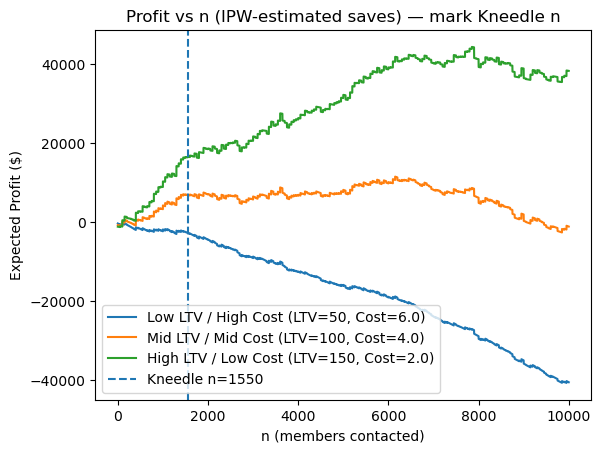

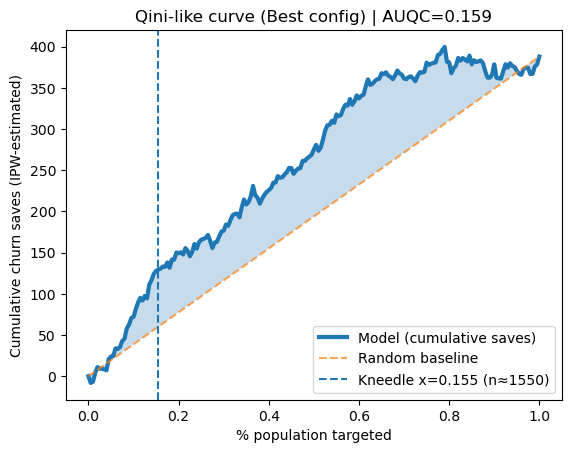


[Summary]
- Best config: K=60, model=A_logreg_tlearner, variant=CHURN_INTENSITY=1.5, AUQC=0.1592
- Kneedle recommends n≈1550 (x=0.155)
- Expected saves at that n: 129.46 (IPW-estimated)
  (ROI table above shows profit sensitivity for LTV=$50–$150 and call cost=$2–$6.)


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

need = [
    "df_summary_ipw",
    "get_XYT","get_ranked_features_from_imp_all","select_topk_X",
    "run_oof_uplift_models_X","qini_curve_and_auqc_ipw",
    "imp_all","stable_hash_int","SEED"
]
missing = [n for n in need if n not in globals()]
if missing:
    raise NameError(f"Missing required objects from previous cells: {missing}")

if "parse_alpha" not in globals():
    def parse_alpha(v):
        if v == "BASE":
            return 0.0
        if isinstance(v, str) and v.startswith("CHURN_INTENSITY="):
            return float(v.split("=")[1])
        return np.nan

if "df_final" in globals():
    DF_ALL = df_final.copy()
else:
    if "build_features" not in globals():
        raise NameError("Need either `df_final` OR `build_features(...)` + raw dfs to reconstruct DF_ALL.")
    web_mode = "counts+conc"
    need_raw = ["df_churn","df_app","df_web","df_claims"]
    missing_raw = [n for n in need_raw if n not in globals()]
    if missing_raw:
        raise NameError(f"Missing raw dfs to build DF_ALL: {missing_raw}")
    DF_ALL = build_features(df_churn, df_app, df_web, df_claims, web_mode=web_mode).copy()

print("[DF_ALL]", DF_ALL.shape, "| churn rate:", float(DF_ALL["churn"].mean()), "| outreach rate:", float(DF_ALL["outreach"].mean()))

if len(df_summary_ipw) == 0:
    raise ValueError("df_summary_ipw is empty.")

best_row = df_summary_ipw.iloc[0].to_dict()
K_best = int(best_row["K_features"])
model_best = str(best_row["model"])
variant_best = str(best_row["variant"])

print("\n[Best config from df_summary_ipw]")
print("  K_features:", K_best)
print("  model:", model_best)
print("  variant:", variant_best)
print("  OOF_AUQC:", float(best_row["OOF_AUQC"]))

X_full, y, t = get_XYT(DF_ALL)
ranked_features = get_ranked_features_from_imp_all(X_full, imp_all=imp_all)
X_best_df, n_used = select_topk_X(X_full, ranked_features, K_best)

print("\n[Recompute OOF] K_features:", K_best, "| n_used:", n_used, "| X_best_df:", X_best_df.shape)
e_hat_best, oof_tau_best, oof_p0_best, _ = run_oof_uplift_models_X(X_best_df, y, t)

if model_best not in oof_tau_best:
    raise KeyError(f"Model `{model_best}` not found in oof_tau_best. موجودים: {list(oof_tau_best.keys())}")

base_tau = oof_tau_best[model_best].astype(float).copy()
base_p0  = np.clip(oof_p0_best[model_best].astype(float).copy(), 1e-6, 1 - 1e-6)

if variant_best == "BASE":
    best_score = base_tau
elif variant_best.startswith("CHURN_INTENSITY="):
    a = parse_alpha(variant_best)
    if not np.isfinite(a):
        raise ValueError(f"Could not parse alpha from variant `{variant_best}`")
    best_score = base_tau * np.power(base_p0, float(a))
elif variant_best == "RAND":
    seed_rand = int(SEED) + 10000 + int(K_best) * 31 + stable_hash_int(model_best, 997)
    rng = np.random.default_rng(seed_rand)
    best_score = rng.standard_normal(len(base_tau)).astype(float)
else:
    raise ValueError(f"Unknown variant `{variant_best}` (expected BASE / CHURN_INTENSITY=... / RAND)")

xs, model_curve, rand_curve, auqc, auqc_raw, overall_uplift = qini_curve_and_auqc_ipw(y, t, e_hat_best, best_score, n_bins=200)

def _moving_average(a, w):
    if w <= 1:
        return a
    w = int(w)
    pad = w // 2
    aa = np.pad(a, (pad, pad), mode="edge")
    kernel = np.ones(w, dtype=float) / w
    return np.convolve(aa, kernel, mode="valid")

def kneedle_knee_x(x, y_net, smooth_w=9):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y_net, dtype=float)
    order = np.argsort(x)
    x = x[order]
    y = y[order]
    y_s = _moving_average(y, smooth_w)
    y_s = np.maximum.accumulate(y_s)
    x_n = (x - x.min()) / max(1e-12, (x.max() - x.min()))
    y_n = (y_s - y_s.min()) / max(1e-12, (y_s.max() - y_s.min()))
    d = y_n - x_n
    i = int(np.argmax(d))
    return x[i], i, y_s, d

net_curve = (model_curve - rand_curve)
x_knee, i_knee, net_smooth, d = kneedle_knee_x(xs, net_curve, smooth_w=9)

N = len(y)
n_knee = max(1, int(round(x_knee * N)))
saved_at_knee = float(model_curve[i_knee])
net_saved_at_knee = float(net_curve[i_knee])

print("\n[KNEEDLE result]")
print(f"  x_knee = {x_knee:.4f}  -> n_knee ≈ {n_knee} (out of N={N})")
print(f"  expected SAVED at n_knee (model_curve) = {saved_at_knee:.2f}")
print(f"  incremental vs random at n_knee (net)  = {net_saved_at_knee:.2f}")
print(f"  AUQC (normalized) = {float(auqc):.4f}")

LTV_grid  = [50, 100, 150]
COST_grid = [2.0, 4.0, 6.0]

roi_rows = []
for LTV in LTV_grid:
    for COST in COST_grid:
        spend = n_knee * COST
        profit = saved_at_knee * LTV - spend
        roi = profit / spend if spend > 0 else np.nan
        roi_rows.append({
            "LTV_$": LTV,
            "CallCost_$": COST,
            "n_kneedle": n_knee,
            "ExpectedSaved@kneedle": saved_at_knee,
            "Spend_$": spend,
            "Profit_$": profit,
            "ROI_(profit/spend)": roi
        })

df_roi = pd.DataFrame(roi_rows).sort_values(["LTV_$","CallCost_$"]).reset_index(drop=True)

print("\n[ROI @ n_kneedle] (Phone outreach sensitivity)")
display(df_roi)

ns = np.arange(1, N + 1)
idx_for_n = np.clip(np.searchsorted((xs * N).astype(int), ns, side="left"), 0, len(xs)-1)
saved_by_n = model_curve[idx_for_n].astype(float)

scenarios = [
    ("Low LTV / High Cost", 50, 6.0),
    ("Mid LTV / Mid Cost", 100, 4.0),
    ("High LTV / Low Cost", 150, 2.0),
]

plt.figure()
for name, LTV, COST in scenarios:
    profit_n = saved_by_n * LTV - ns * COST
    plt.plot(ns, profit_n, label=f"{name} (LTV={LTV}, Cost={COST})")
plt.axvline(n_knee, linestyle="--", label=f"Kneedle n={n_knee}")
plt.xlabel("n (members contacted)")
plt.ylabel("Expected Profit ($)")
plt.title("Profit vs n (IPW-estimated saves) — mark Kneedle n")
plt.legend()
plt.show()

plt.figure()
plt.plot(xs, model_curve, linewidth=3, label="Model (cumulative saves)")
plt.plot(xs, rand_curve, linestyle="--", alpha=0.7, label="Random baseline")
plt.fill_between(xs, rand_curve, model_curve, alpha=0.25)
plt.axvline(x_knee, linestyle="--", label=f"Kneedle x={x_knee:.3f} (n≈{n_knee})")
plt.xlabel("% population targeted")
plt.ylabel("Cumulative churn saves (IPW-estimated)")
plt.title(f"Qini-like curve (Best config) | AUQC={float(auqc):.3f}")
plt.legend()
plt.show()

print("\n[Summary]")
print(f"- Best config: K={K_best}, model={model_best}, variant={variant_best}, AUQC={float(auqc):.4f}")
print(f"- Kneedle recommends n≈{n_knee} (x={x_knee:.3f})")
print(f"- Expected saves at that n: {saved_at_knee:.2f} (IPW-estimated)")
print("  (ROI table above shows profit sensitivity for LTV=$50–$150 and call cost=$2–$6.)")


# 6 - GENERATE TEST SET SCORES TOP N

In [7]:
import os
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

need = ["build_features", "get_XYT", "imp_all"]
missing = [x for x in need if x not in globals()]
if missing:
    raise NameError("Missing globals: " + ", ".join(missing))

WEB_MODE = "counts+conc"
K_BEST   = 60
ALPHA    = 1.5
N_TOP    = 1550

if "DF_TRAIN" in globals():
    DF_TRAIN = DF_TRAIN.copy()
elif "DF_ALL" in globals():
    DF_TRAIN = DF_ALL.copy()
elif "df_final" in globals():
    DF_TRAIN = df_final.copy()
else:
    need_raw = ["df_churn","df_app","df_web","df_claims"]
    missing_raw = [n for n in need_raw if n not in globals()]
    if missing_raw:
        raise NameError("Missing train dataframe(s): " + ", ".join(missing_raw))
    DF_TRAIN = build_features(df_churn, df_app, df_web, df_claims, web_mode=WEB_MODE).copy()

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE_DIR, "data")
TEST_DIR = os.path.join(DATA_DIR, "test")

paths = {
    "members": os.path.join(TEST_DIR, "test_members.csv"),
    "app":     os.path.join(TEST_DIR, "test_app_usage.csv"),
    "web":     os.path.join(TEST_DIR, "test_web_visits.csv"),
    "claims":  os.path.join(TEST_DIR, "test_claims.csv"),
}
for k, p in paths.items():
    if not os.path.exists(p):
        raise FileNotFoundError(f"Missing test file: {p}")

df_test_members = pd.read_csv(paths["members"])
df_test_app     = pd.read_csv(paths["app"])
df_test_web     = pd.read_csv(paths["web"])
df_test_claims  = pd.read_csv(paths["claims"])

for df in [df_test_members, df_test_app, df_test_web, df_test_claims]:
    if "member_id" not in df.columns:
        raise ValueError("One of the test tables is missing 'member_id'")
    df["member_id"] = pd.to_numeric(df["member_id"], errors="coerce")

if "signup_date" in df_test_members.columns:
    df_test_members["signup_date"] = pd.to_datetime(df_test_members["signup_date"], errors="coerce")

for dfx in [df_test_app, df_test_web]:
    if "timestamp" in dfx.columns:
        dfx["timestamp"] = pd.to_datetime(dfx["timestamp"], errors="coerce")

if "diagnosis_date" in df_test_claims.columns:
    df_test_claims["diagnosis_date"] = pd.to_datetime(df_test_claims["diagnosis_date"], errors="coerce")

df_test_members = df_test_members.dropna(subset=["member_id"]).copy()
df_test_members["member_id"] = df_test_members["member_id"].astype(int)

for dfx in [df_test_app, df_test_web, df_test_claims]:
    dfx.dropna(subset=["member_id"], inplace=True)
    dfx["member_id"] = dfx["member_id"].astype(int)

mem_ids = set(df_test_members["member_id"].tolist())

def _overlap(ids_series):
    return len(mem_ids.intersection(set(ids_series.astype(int).tolist())))

ov_app0   = _overlap(df_test_app["member_id"]) if len(df_test_app) else 0
ov_web0   = _overlap(df_test_web["member_id"]) if len(df_test_web) else 0
ov_clm0   = _overlap(df_test_claims["member_id"]) if len(df_test_claims) else 0
ov0_sum   = ov_app0 + ov_web0 + ov_clm0

mem_min = int(df_test_members["member_id"].min())

cand = set([0])
for src_df in [df_test_app, df_test_web, df_test_claims]:
    if len(src_df) == 0:
        continue
    src_min = int(src_df["member_id"].min())
    src_max = int(src_df["member_id"].max())
    cand.add(mem_min - src_min)
    cand.add(mem_min - 1)
    cand.add(mem_min - src_max)
cand = sorted(cand)

def _score_delta(delta):
    o1 = _overlap(df_test_app["member_id"] + delta) if len(df_test_app) else 0
    o2 = _overlap(df_test_web["member_id"] + delta) if len(df_test_web) else 0
    o3 = _overlap(df_test_claims["member_id"] + delta) if len(df_test_claims) else 0
    return (o1 + o2 + o3), o1, o2, o3

best = None
for d in cand:
    s = _score_delta(d)
    if (best is None) or (s[0] > best[0]):
        best = (s[0], d, s[1], s[2], s[3])

best_sum, best_delta, ov_app, ov_web, ov_clm = best

print("=== TEST ID alignment ===")
print(f"Overlap BEFORE shift: app={ov_app0}, web={ov_web0}, claims={ov_clm0} (sum={ov0_sum})")
print(f"Best delta found: {best_delta} | Overlap AFTER shift: app={ov_app}, web={ov_web}, claims={ov_clm} (sum={best_sum})")

if best_sum == 0:
    raise RuntimeError("Could not align test log tables to test_members via a simple delta. Check test files.")

if len(df_test_app):
    df_test_app["member_id"] = (df_test_app["member_id"] + best_delta).astype(int)
if len(df_test_web):
    df_test_web["member_id"] = (df_test_web["member_id"] + best_delta).astype(int)
if len(df_test_claims):
    df_test_claims["member_id"] = (df_test_claims["member_id"] + best_delta).astype(int)

DF_TEST = build_features(df_test_members, df_test_app, df_test_web, df_test_claims, web_mode=WEB_MODE).copy()

X_train_full, y_train, t_train = get_XYT(DF_TRAIN)

DF_TEST_tmp = DF_TEST.copy()
DF_TEST_tmp["churn"] = 0
DF_TEST_tmp["outreach"] = 0
X_test_full, _, _ = get_XYT(DF_TEST_tmp)

ranked_features = get_ranked_features_from_imp_all(X_train_full, imp_all=imp_all)
top_feats = [f for f in ranked_features[:K_BEST] if f in X_train_full.columns]
if len(top_feats) != K_BEST:
    raise RuntimeError(f"Top-features mismatch: expected {K_BEST}, got {len(top_feats)}")

X_test_aligned = X_test_full.copy()
for c in top_feats:
    if c not in X_test_aligned.columns:
        if (X_train_full[c].dtype == "object") or str(X_train_full[c].dtype).startswith("category"):
            X_test_aligned[c] = "NA"
        else:
            X_test_aligned[c] = 0

X_train_sel = X_train_full[top_feats].copy()
X_test_sel  = X_test_aligned[top_feats].copy()

cat_cols = [c for c in X_train_sel.columns if (X_train_sel[c].dtype == "object") or str(X_train_sel[c].dtype).startswith("category")]
num_cols = [c for c in X_train_sel.columns if c not in cat_cols]

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=True, with_std=True), num_cols),
        ("cat", ohe, cat_cols),
    ],
    remainder="drop"
)

Xtr = pre.fit_transform(X_train_sel)
Xte = pre.transform(X_test_sel)

m0 = LogisticRegression(solver="lbfgs", max_iter=5000, n_jobs=-1, class_weight="balanced", C=0.7)
m1 = LogisticRegression(solver="lbfgs", max_iter=5000, n_jobs=-1, class_weight="balanced", C=0.7)

mask0 = (t_train == 0)
mask1 = (t_train == 1)
m0.fit(Xtr[mask0], y_train[mask0])
m1.fit(Xtr[mask1], y_train[mask1])

p0 = np.clip(m0.predict_proba(Xte)[:, 1], 1e-6, 1 - 1e-6)
p1 = np.clip(m1.predict_proba(Xte)[:, 1], 1e-6, 1 - 1e-6)
tau = p0 - p1
score = tau * (p0 ** ALPHA)
score = np.maximum(score, 0.0)

print("\n=== QUICK SCORE SANITY (TEST) ===")
print("p0  min/median/max:", float(np.min(p0)), float(np.median(p0)), float(np.max(p0)))
print("tau min/median/max:", float(np.min(tau)), float(np.median(tau)), float(np.max(tau)))
print("score min/median/max:", float(np.min(score)), float(np.median(score)), float(np.max(score)))

out = pd.DataFrame({
    "member_id": DF_TEST["member_id"].astype(int).values,
    "prioritization_score": score
}).sort_values("prioritization_score", ascending=False).reset_index(drop=True)

out = out.head(N_TOP).copy()
out["rank"] = np.arange(1, len(out) + 1)

out_path = os.path.join(BASE_DIR, "submission.csv")
out.to_csv(out_path, index=False)

print(f"\nWrote: {out_path} | shape={out.shape}")
print(out.head(10))


=== TEST ID alignment ===
Overlap BEFORE shift: app=0, web=0, claims=0 (sum=0)
Best delta found: 20000 | Overlap AFTER shift: app=9998, web=9981, claims=9978 (sum=29957)


/home/weizyuv/vi_labs_assignment/notebooks/../src/feature_engineering.py:465: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[name] = feature_df["member_id"].map(ser).fillna(0)
/home/weizyuv/vi_labs_assignment/notebooks/../src/feature_engineering.py:467: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df["wellco_engagement"] = (



=== QUICK SCORE SANITY (TEST) ===
p0  min/median/max: 0.001167173476637938 0.4827149482580063 0.999999
tau min/median/max: -0.6467591188355284 0.048553207857259036 0.3925172626836458
score min/median/max: 0.0 0.01343057878323786 0.3194974899234603

Wrote: /home/weizyuv/vi_labs_assignment/submission.csv | shape=(1550, 3)
   member_id  prioritization_score  rank
0      21859              0.319497     1
1      28072              0.266409     2
2      29422              0.259253     3
3      21775              0.233650     4
4      29085              0.228252     5
5      20914              0.224779     6
6      20075              0.213395     7
7      22910              0.210301     8
8      21047              0.202009     9
9      28256              0.198422    10


# 7 TEST SANITY CHECK

In [8]:
# ============================================================
# CELL — SANITY REPORT (TRAIN vs TEST) for FINAL PIPELINE
#   - Uses your existing build_features / get_XYT / select_topk_X / imp_all ranking
#   - Checks: ids, duplicates, missingness, datetime coercion, feature alignment
#   - Checks: score distribution + top-n basic stats
#   - Does NOT refit anything (expects you already ran the submission cell)
# ============================================================

import numpy as np
import pandas as pd

# -------------------------
# Required globals (from your notebook)
# -------------------------
need = [
    "build_features",
    "get_XYT",
    "get_ranked_features_from_imp_all",
    "select_topk_X",
    "imp_all",
]
missing = [nm for nm in need if nm not in globals()]
if missing:
    raise NameError(f"Missing required object(s): {missing}. Run your definitions/feature-selection cells first.")

# From your submission cell we expect these to exist:
need2 = ["DF_TRAIN", "DF_TEST", "X_train_sel", "X_test_sel", "score", "tau", "p0", "p1", "out"]
missing2 = [nm for nm in need2 if nm not in globals()]
if missing2:
    raise NameError(
        f"Missing output(s) from the submission cell: {missing2}. "
        "Run the submission cell first so this sanity report can inspect it."
    )

# Optional config values (set defaults if not defined)
K_BEST     = globals().get("K_BEST", 60)
ALPHA_BEST = globals().get("ALPHA_BEST", 1.5)
N_NEEDLE   = globals().get("N_NEEDLE", 1550)
WEB_MODE   = globals().get("WEB_MODE", "counts+conc")

def pct(x):
    return 100.0 * float(x)

def print_hdr(title):
    print("\n" + "="*90)
    print(title)
    print("="*90)

# -------------------------
# 1) Basic shape + key columns
# -------------------------
print_hdr("1) BASIC SHAPES + KEYS")

print("[TRAIN] DF_TRAIN shape:", DF_TRAIN.shape)
print("[TEST ] DF_TEST  shape:", DF_TEST.shape)

for name, df in [("TRAIN", DF_TRAIN), ("TEST", DF_TEST)]:
    if "member_id" not in df.columns:
        raise ValueError(f"[{name}] missing member_id column.")
    n = len(df)
    nunq = df["member_id"].nunique(dropna=True)
    n_na = df["member_id"].isna().sum()
    n_dup = n - nunq
    print(f"[{name}] member_id: n={n} unique={nunq} dup={n_dup} missing={n_na}")

# membership overlap
train_ids = set(DF_TRAIN["member_id"].dropna().astype(str).values)
test_ids  = set(DF_TEST["member_id"].dropna().astype(str).values)
overlap = len(train_ids.intersection(test_ids))
print(f"[Overlap] train∩test member_id: {overlap} (should usually be 0; if not, flag it)")

# -------------------------
# 2) Datetime coercion sanity (common failure source)
# -------------------------
print_hdr("2) DATETIME SANITY (signup_date / timestamp / diagnosis_date)")

def datetime_col_report(df, col, label):
    if col not in df.columns:
        print(f"[{label}] {col}: (missing column)")
        return
    s = df[col]
    # If object, try to parse a sample to see if it's truly datetime-like
    if not np.issubdtype(s.dtype, np.datetime64):
        parsed = pd.to_datetime(s, errors="coerce")
        bad = parsed.isna().sum()
        print(f"[{label}] {col}: dtype={s.dtype} | parsed_NaT={bad}/{len(s)} ({pct(bad/len(s)):.2f}%)")
    else:
        bad = s.isna().sum()
        print(f"[{label}] {col}: dtype=datetime64 | NaT={bad}/{len(s)} ({pct(bad/len(s)):.2f}%)")

datetime_col_report(DF_TRAIN, "signup_date", "TRAIN")
datetime_col_report(DF_TEST,  "signup_date", "TEST")

# Raw tables (if present) — helpful to catch parsing issues
for raw_name, col in [
    ("df_app", "timestamp"), ("df_web", "timestamp"), ("df_claims", "diagnosis_date"),
    ("df_test_app", "timestamp"), ("df_test_web", "timestamp"), ("df_test_claims", "diagnosis_date"),
]:
    if raw_name in globals():
        datetime_col_report(globals()[raw_name], col, raw_name)

# -------------------------
# 3) Feature alignment sanity
# -------------------------
print_hdr("3) FEATURE ALIGNMENT (TRAIN top-K vs TEST)")

train_cols = list(X_train_sel.columns)
test_cols  = list(X_test_sel.columns)

print("[Selected features] K_BEST:", K_BEST, "| n_used:", len(train_cols))
print("[Aligned columns]   train_cols == test_cols ?", train_cols == test_cols)

missing_in_test = [c for c in train_cols if c not in test_cols]
extra_in_test   = [c for c in test_cols if c not in train_cols]
print("[Alignment] missing_in_test:", len(missing_in_test))
print("[Alignment] extra_in_test  :", len(extra_in_test))
if len(missing_in_test) > 0:
    print("  First missing:", missing_in_test[:20])
if len(extra_in_test) > 0:
    print("  First extra:", extra_in_test[:20])

# Missingness in selected X
def missingness_report(X_df, label, top=12):
    miss = X_df.isna().mean().sort_values(ascending=False)
    miss_top = miss[miss > 0].head(top)
    print(f"[{label}] NaN columns (top {top}):")
    if len(miss_top) == 0:
        print("  none ✅")
    else:
        print(miss_top)

missingness_report(X_train_sel, "TRAIN X_sel")
missingness_report(X_test_sel,  "TEST  X_sel")

# -------------------------
# 4) Model score sanity (distribution + extreme values)
# -------------------------
print_hdr("4) SCORE / TAU DISTRIBUTIONS (TEST)")

def describe_arr(a, name):
    a = np.asarray(a, dtype=float)
    print(f"[{name}] n={len(a)}")
    print(f"  min/1%/5%/median/95%/99%/max:")
    qs = np.quantile(a, [0.0, 0.01, 0.05, 0.50, 0.95, 0.99, 1.0])
    print(" ", ", ".join([f"{q:.6f}" for q in qs]))
    print(f"  mean/std: {float(np.mean(a)):.6f} / {float(np.std(a)):.6f}")
    print(f"  >0 count: {int(np.sum(a > 0))} ({pct(np.mean(a > 0)):.2f}%)")

describe_arr(p0,   "p0 (pred churn if NO outreach)")
describe_arr(p1,   "p1 (pred churn if outreach)")
describe_arr(tau,  "tau = p0 - p1")
describe_arr(score,"score = tau * (p0^alpha)")

# Quick monotonic sanity: top score should be >= bottom score
order = np.argsort(-score)
print("[Score order sanity] best_score:", float(score[order[0]]), "| worst_score:", float(score[order[-1]]))

# -------------------------
# 5) Top-n output sanity (n=needle)
# -------------------------
print_hdr("5) TOP-n OUTPUT SANITY")

if not {"member_id","prioritization_score","rank"}.issubset(out.columns):
    raise ValueError("`out` must have columns: member_id, prioritization_score, rank")

print("[out] shape:", out.shape)
print("[out] rank min/max:", int(out["rank"].min()), int(out["rank"].max()))
print("[out] unique member_id:", out["member_id"].nunique(), " / rows:", len(out))

dup_out = len(out) - out["member_id"].nunique()
print("[out] duplicate member_ids:", dup_out)

# score should be descending with rank
bad_order = (out["prioritization_score"].values[:-1] < out["prioritization_score"].values[1:]).sum()
print("[out] ordering violations (should be 0):", int(bad_order))

# show top/bottom
print("\n[out] TOP 10:")
display(out.head(10))
print("\n[out] BOTTOM 10:")
display(out.tail(10))

# -------------------------
# 6) (Optional) Train label sanity (to ensure no leakage fields remained)
# -------------------------
print_hdr("6) TRAIN LABEL SANITY (churn/outreach presence and rates)")

if ("churn" not in DF_TRAIN.columns) or ("outreach" not in DF_TRAIN.columns):
    print("[WARN] DF_TRAIN missing churn/outreach columns (unexpected if DF_TRAIN is from build_features).")
else:
    churn_rate = float(DF_TRAIN["churn"].mean())
    outreach_rate = float(DF_TRAIN["outreach"].mean())
    print(f"[TRAIN] churn_rate={churn_rate:.4f} | outreach_rate={outreach_rate:.4f}")

# -------------------------
# Summary line
# -------------------------
print_hdr("SANITY SUMMARY")
print(f"Config: model=A_logreg_tlearner | K={K_BEST} | alpha={ALPHA_BEST} | web_mode={WEB_MODE} | n={N_NEEDLE}")
print("If overlap(train,test) > 0 or out has duplicates/order violations, fix before pushing to git/submission.")



1) BASIC SHAPES + KEYS
[TRAIN] DF_TRAIN shape: (10000, 105)
[TEST ] DF_TEST  shape: (10000, 103)
[TRAIN] member_id: n=10000 unique=10000 dup=0 missing=0
[TEST] member_id: n=10000 unique=10000 dup=0 missing=0
[Overlap] train∩test member_id: 0 (should usually be 0; if not, flag it)

2) DATETIME SANITY (signup_date / timestamp / diagnosis_date)
[TRAIN] signup_date: dtype=datetime64 | NaT=0/10000 (0.00%)
[TEST] signup_date: dtype=datetime64 | NaT=0/10000 (0.00%)
[df_app] timestamp: dtype=datetime64 | NaT=0/97789 (0.00%)
[df_web] timestamp: dtype=datetime64 | NaT=0/259340 (0.00%)
[df_claims] diagnosis_date: dtype=datetime64 | NaT=0/64576 (0.00%)
[df_test_app] timestamp: dtype=datetime64 | NaT=0/97961 (0.00%)
[df_test_web] timestamp: dtype=datetime64 | NaT=0/261729 (0.00%)
[df_test_claims] diagnosis_date: dtype=datetime64 | NaT=0/64803 (0.00%)

3) FEATURE ALIGNMENT (TRAIN top-K vs TEST)
[Selected features] K_BEST: 60 | n_used: 60
[Aligned columns]   train_cols == test_cols ? True
[Alignment

,member_id,prioritization_score,rank
0,21859,0.319497,1
1,28072,0.266409,2
2,29422,0.259253,3
3,21775,0.233650,4
4,29085,0.228252,5
5,20914,0.224779,6
6,20075,0.213395,7
7,22910,0.210301,8
8,21047,0.202009,9
9,28256,0.198422,10



[out] BOTTOM 10:


,member_id,prioritization_score,rank
1540,24902,0.052946,1541
1541,21023,0.052922,1542
1542,29075,0.052918,1543
1543,26968,0.052894,1544
1544,20125,0.052893,1545
1545,29797,0.052883,1546
1546,27296,0.052855,1547
1547,20424,0.052850,1548
1548,21005,0.052837,1549
1549,21609,0.052793,1550



6) TRAIN LABEL SANITY (churn/outreach presence and rates)
[TRAIN] churn_rate=0.2021 | outreach_rate=0.3984

SANITY SUMMARY
Config: model=A_logreg_tlearner | K=60 | alpha=1.5 | web_mode=counts+conc | n=1550
If overlap(train,test) > 0 or out has duplicates/order violations, fix before pushing to git/submission.
